In [2]:
%matplotlib ipympl
import numpy as np
import math
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def particle_collision_time(pos_i, vel_i, pos_j, vel_j, particle_radius, large_num):
    delta_x = pos_j[0] - pos_i[0]
    delta_vx = vel_j[0] - vel_i[0]
    delta_y = pos_j[1] - pos_i[1]
    delta_vy = vel_j[1] - vel_i[1]
    #print(f'delta_x:{delta_x}, delta_y:{delta_y}, delta_vy:{delta_vy}, delta_vx:{delta_vx}')
    a = delta_vx**2 + delta_vy**2
    b = 2 * (delta_x * delta_vx + delta_y * delta_vy)
    c = delta_x**2 + delta_y**2 - 4 * particle_radius**2  # Adjusting for radius
    
    if a == 0:
        return large_num  # Particles moving parallel (no collision)
    
    Delta = b**2 - 4 * a * c
    if Delta < 0:
        return large_num  # No real roots, no collision
    elif Delta == 0:
        t = -b / (2 * a)
        return t if t >= 0 else large_num
    else:
        t1 = (-b + math.sqrt(Delta)) / (2 * a)
        t2 = (-b - math.sqrt(Delta)) / (2 * a)
        if t1 >= 0 and t2 >= 0:
            #print(f'delta>0 and {t1} and {t2}')
            return min(t1, t2)
        elif t1 >= 0:
            return t1
        elif t2 >= 0:
            return t2
        return large_num

# Function to compute the time to collision with the walls
def wall_collision_time(position, velocity, box_size, particle_radius, large_num):
    times = []
    for i in range(2):  # x and y directions
        if velocity[i] > 0:
            t_wall = (box_size - particle_radius - position[i]) / velocity[i]
        elif velocity[i] < 0:
            t_wall = (particle_radius - position[i]) / velocity[i]
        else:
            t_wall = large_num  # No movement in this direction
        times.append(t_wall)
    
    return min(times)

# Function to find the next collision event
def find_earliest_collision(positions, velocities, num_particles, large_num, box_size, particle_radius):
    min_time = large_num
    collision_pair = (-1, -1)  # (-1, -1) means wall collision
    
    # Check particle-particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            t_collision = particle_collision_time(positions[i], velocities[i], positions[j], velocities[j], particle_radius, large_num)
            if t_collision < min_time:
                min_time = t_collision
                #print(min_time)
                collision_pair = (i, j)
    
    # Check particle-wall collisions
    for i in range(num_particles):
        t_wall = wall_collision_time(positions[i], velocities[i], box_size, particle_radius, large_num)
        if t_wall < min_time:
            min_time = t_wall
            collision_pair = (i, -1)  # Indicate wall collision for this particle
    
    return min_time, collision_pair
def update_positions(positions, velocities, dt, collision_pair, pressure, box_size, num_particles, particle_radius):
    # Update positions
    positions += velocities * dt
    #print(f'dist is {np.linalg.norm(positions[p] - positions[q])}')
    #print(positions)
    # Check for boundary collisions and reflect velocities
    for i in range(num_particles):
        for j in range(2):  # x and y directions
            if positions[i, j] <= particle_radius or positions[i, j] >= box_size - particle_radius:
                velocities[i, j] *= -1
                
                pressure += abs(velocities[i, j])
                positions[i, j] = np.clip(positions[i, j], particle_radius, box_size - particle_radius)
                #print(f'wall collision for {i} at {dt}s and position:{positions[i]}')
                #print(f'({i}, {j})position of wall colision {positions[i]} and new v:{velocities[i]}')
    # Check for particle collisions
    for i in range(num_particles):
        for j in range(i + 1, num_particles):
            dist = np.linalg.norm(positions[i] - positions[j])
            if dist <= 2 * particle_radius:  # Collision condition
                #print(f'for {i}, {j} we have a collision at position{positions[i]} and {positions[j]},dist:{dist}')
                velocities = resolve_collision(i, j, positions, velocities)
    positions += velocities * 0.000001
    
    return pressure, positions, velocities
# Function to resolve the collision (particles or walls)
def resolve_collision(i, j, positions, velocities):
    # Calculate the normal vector
    delta_pos = positions[i] - positions[j]
    dist = np.linalg.norm(delta_pos)
    delta_v = velocities[i] - velocities[j]
    # Normal vector
    n_hat = delta_pos / (dist**2)
    #print(f'dist is {dist}')
    # Relative velocity
    
    
    # Velocity component along the normal direction
    v_rel = np.dot(delta_v, delta_pos)
    
    # Update velocities if particles are moving towards each other
    if v_rel < 0:
        velocities[i] -= v_rel * n_hat
        velocities[j] += v_rel * n_hat
    return velocities
    #print(f'({i},{j}) new i: p:{positions[i]}, v:{velocities[i]}\n and j: p:{positions[j]},v:{velocities[j]}')

    
#Visualization setup
# fig, ax = plt.subplots()
# ax.set_xlim(0, box_size)
# ax.set_ylim(0, box_size)
# particles, = ax.plot([], [], 'bo', ms=10)

# def init():
#     particles.set_data([], [])
#     return particles,

# def animate(frame):
#     global positions, velocities, dt, pressure
    
#     # Find the earliest collision
#     delta_t, collision_pair = find_earliest_collision(positions, velocities)
    
#     # Update positions to the collision time
#     if delta_t < dt:
#         delta_t += 0.000001
#         pressure, positions = update_positions(positions, velocities, delta_t, collision_pair, pressure)
#         dt -= (delta_t + 0.000001)
#     else:
#         pressure, positions = update_positions(positions, velocities, dt, collision_pair, pressure)
#         dt = 0.1  # Reset time step after each update
    
#     particles.set_data(positions[:, 0], positions[:, 1])
#     return particles,

# # Animation
# ani = animation.FuncAnimation(fig, animate, frames=int(t_max/dt), init_func=init,
#                               interval=20, blit=True, repeat=False)

# plt.show()




In [2]:
def molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities):
    box_size = box_dim
    pressure = 0
    # Initialize positions and velocities
    
    # Function to compute the time to the first collision between two particles
    
    t = 0
    while t < t_max:
        delta_t, collision_pair = find_earliest_collision(positions, velocities,num_particles, large_num, box_size, particle_radius)
        
        delta_t += 0.000001
        pressure, positions, velocities = update_positions(positions, velocities, delta_t, collision_pair, pressure, box_size, num_particles, particle_radius)
        t += (delta_t + 0.000001)
    return pressure

In [25]:
# Box dimensions
box_dim = 100

# Number of particles
num_particles = 25
particle_radius = 2.0  # Radius of the particles
large_num = 100 # A large number for no collision
epsilon = 1e-5  # Small threshold to avoid repeated collisions

# Time parameters
t_max = 500 # Total simulation time
dt = 0.1
box_dims = np.arange(50, 500, 50)
volum = box_dims**2
all_press = []
np.random.seed(0)  # For reproducibility
positions = np.random.rand(num_particles, 2) * (box_dim - 2 * particle_radius) + particle_radius
velocities = (np.random.rand(num_particles, 2) - 0.5) * 10
velocities *= 0.1
vs = np.linalg.norm(velocities, axis=1)**2
temp = np.mean(vs)
for box_dim in box_dims:
    
    pressure = molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities)
    pressure = pressure / t_max
    all_press.append(pressure)
print(all_press)

[0.0029757001031533344, 0.0028344982438331104, -0.000873780605515996, -0.004693941756225001, 0.008095176268400823, -3.223749086414396e-05, -0.0018026213361188423, -0.0003091623482154052]


In [67]:
# Box dimensions
box_dim = 100

# Number of particles
num_particles = 25
particle_per_dim = 5
particle_radius = 2.0  # Radius of the particles
large_num = 100 # A large number for no collision
epsilon = 1e-5  # Small threshold to avoid repeated collisions

# Time parameters
t_max = 500 # Total simulation time
dt = 0.1

In [51]:


all_press = []
box_dims = np.arange(35, 285, 5)
volum = box_dims**2
v_multipliers = np.arange(1.0, 11.0, 0.2)
# v_multipliers = np.ones((50, 1))
iterating = list(zip(box_dims, v_multipliers))
temps = []
for i in iterating:
    box_dim, multiplier = i
    np.random.seed(0)  # For reproducibility
    positions = np.random.rand(num_particles, 2) * (box_dim - 2 * particle_radius) + particle_radius
    velocities = (np.random.rand(num_particles, 2) - 0.5) * 10
    velocities *= multiplier
    vs = np.linalg.norm(velocities, axis=1)**2
    temp = np.mean(vs)
    temps.append(temp)
    pressure = molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities)
    pressure = pressure / t_max
    all_press.append(pressure)
print(all_press)
np.savetxt('pressure.csv', all_press, delimiter=',')
np.savetxt('volum.csv', volum, delimiter=',')
np.savetxt('temp.csv', temps, delimiter=',')

[43.67250407701437, 27.492929359144796, 20.04916580750417, 15.939476664665657, 13.269048663787382, 11.259718053312659, 9.88815892702549, 8.864367447062785, 7.9500445999914655, 7.278708681323431, 6.672536003083121, 6.237725914712787, 5.7971638945772686, 5.4346712962024055, 5.11910028404544, 4.8410384133937745, 4.566260675608732, 4.339708001135975, 4.137998491433048, 3.953774915003979, 3.798813861804456, 3.635682225718123, 3.5251741986778455, 3.347059950201688, 3.225513774783445, 3.11007379617664, 3.0246034020544843, 2.937973134526692, 2.8278577501096933, 2.7369571802711543, 2.674560021416093, 2.5921952007368683, 2.5193398041258495, 2.4357756838790414, 2.387202734153218, 2.3111911076741105, 2.271026737134209, 2.210169104671877, 2.1746323358457023, 2.1058528654446076, 2.055182647205052, 1.9951746390755247, 1.9663945244538439, 1.932514304424224, 1.887399879008517, 1.8445387141609197, 1.8149346675654436, 1.7643809165457032, 1.7384784396692237, 1.7183337802844112]


In [116]:
# Nested fors
all_press = []
box_dims = np.arange(45, 120, 5)
volum = box_dims**2
v_multipliers = np.arange(2.0, 10.0, 1)
# v_multipliers = np.ones((50, 1))
iterating = list(zip(box_dims, v_multipliers))
temps = []

        
for box_dim in box_dims:
    for multiplier in v_multipliers:
        
        np.random.seed(0)
        xs = np.linspace(particle_radius+0.05, box_dim-particle_radius-0.05, particle_per_dim, endpoint=False)
        positions = []
        for i in xs:
            for j in xs:
                positions.append([i,j])
        positions = np.array(positions)
        velocities = (np.random.rand(num_particles, 2) - 0.5) * 10
        velocities *= multiplier
        vs = np.linalg.norm(velocities, axis=1)**2
        temp = np.mean(vs)
        temps.append(temp)
        pressure = molecular_sim(box_dim, num_particles, particle_radius, t_max, large_num, positions, velocities)
        pressure = pressure / t_max
        all_press.append(pressure)
print(all_press)
np.savetxt('pressure.csv', all_press, delimiter=',')
np.savetxt('volum.csv', volum, delimiter=',')
np.savetxt('temp.csv', temps, delimiter=',')

[52.229325050538385, 117.2938201586005, 207.97578505247807, 326.33416077902785, 468.77020599465624, 636.6022098458058, 835.7175019023189, 1054.95997635111, 43.12687463225686, 97.24646679763894, 172.88817222545228, 270.19721308412653, 388.2612932210894, 530.147655293377, 692.0677333030642, 873.3311645946824, 37.12546778240024, 83.18198190098856, 147.7695390395355, 231.11218491881064, 333.90408644093344, 453.0592901547038, 590.650063093495, 749.3048272186309, 32.31898572201991, 72.8489992087649, 129.63559002545546, 203.26826973167016, 291.9159412830227, 397.1346876410063, 519.1859640148871, 657.06871497271, 29.00430183046761, 65.11059204870534, 115.9732790305829, 181.0036531982854, 260.23827271107615, 354.8781344192771, 463.2675556813375, 585.8409460711258, 25.940241299536382, 58.7204348152524, 104.48461654773595, 163.3597623208712, 235.4879417906651, 319.9698141836856, 417.8033732287583, 529.4879373708451, 23.869384282251318, 53.63131299055334, 95.3330594660587, 149.25613739993238, 215.

In [68]:
xs = np.linspace(particle_radius+0.05, box_dim-particle_radius-0.05, 5, endpoint=False)
positions = []
for i in xs:
    for j in xs:
        positions.append([i,j])

In [121]:
box_dims = np.arange(45, 120, 5)
volum = box_dims**2
v_multipliers = np.arange(2.0, 10.0, 1)
print(f'{len(box_dims)}, {len(v_multipliers)}')

15, 8


In [122]:
all_press = np.genfromtxt('pressure.csv', delimiter=',')
volum = np.genfromtxt('volum.csv', delimiter=',')
temp = np.genfromtxt('temp.csv', delimiter=',')

In [123]:
volum = []
for box_dim in box_dims:
    for multiplier in v_multipliers:
        volum.append(box_dim**2)
volum = np.array(volum)
volum

array([ 2025,  2025,  2025,  2025,  2025,  2025,  2025,  2025,  2500,
        2500,  2500,  2500,  2500,  2500,  2500,  2500,  3025,  3025,
        3025,  3025,  3025,  3025,  3025,  3025,  3600,  3600,  3600,
        3600,  3600,  3600,  3600,  3600,  4225,  4225,  4225,  4225,
        4225,  4225,  4225,  4225,  4900,  4900,  4900,  4900,  4900,
        4900,  4900,  4900,  5625,  5625,  5625,  5625,  5625,  5625,
        5625,  5625,  6400,  6400,  6400,  6400,  6400,  6400,  6400,
        6400,  7225,  7225,  7225,  7225,  7225,  7225,  7225,  7225,
        8100,  8100,  8100,  8100,  8100,  8100,  8100,  8100,  9025,
        9025,  9025,  9025,  9025,  9025,  9025,  9025, 10000, 10000,
       10000, 10000, 10000, 10000, 10000, 10000, 11025, 11025, 11025,
       11025, 11025, 11025, 11025, 11025, 12100, 12100, 12100, 12100,
       12100, 12100, 12100, 12100, 13225, 13225, 13225, 13225, 13225,
       13225, 13225, 13225])

In [124]:
print(f'len of v is {len(volum)}, and len of press:{len(all_press)}, len of temp:{len(temp)}')

len of v is 120, and len of press:120, len of temp:120


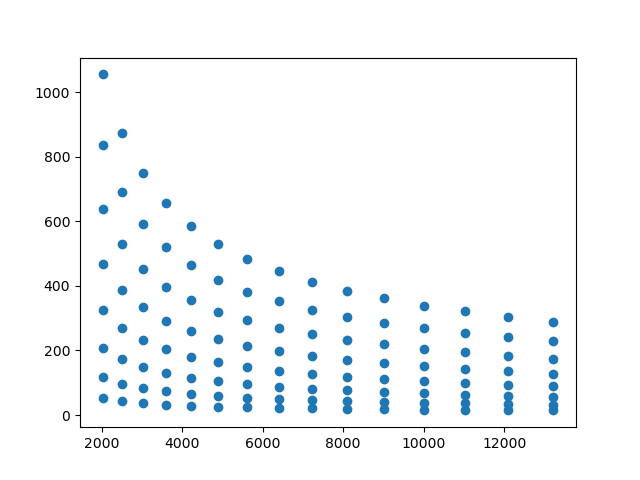

In [130]:
fig = plt.Figure()
plt.scatter(volum, all_press)
plt.show()

ValueError: x and y must be the same size

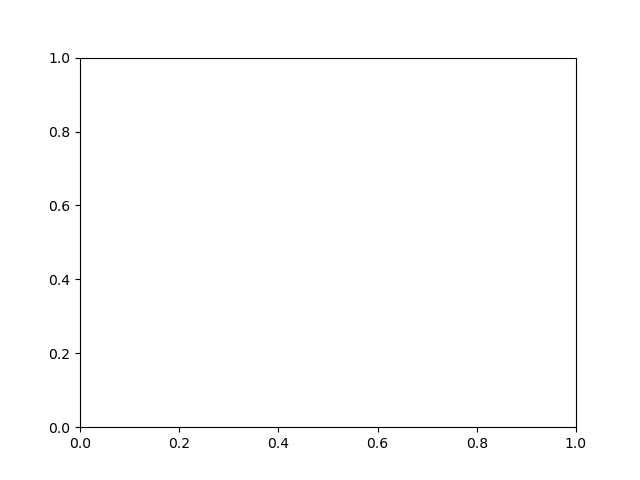

In [129]:
plt.figure()
plt.scatter(all_press, v_multipliers)
plt.show()

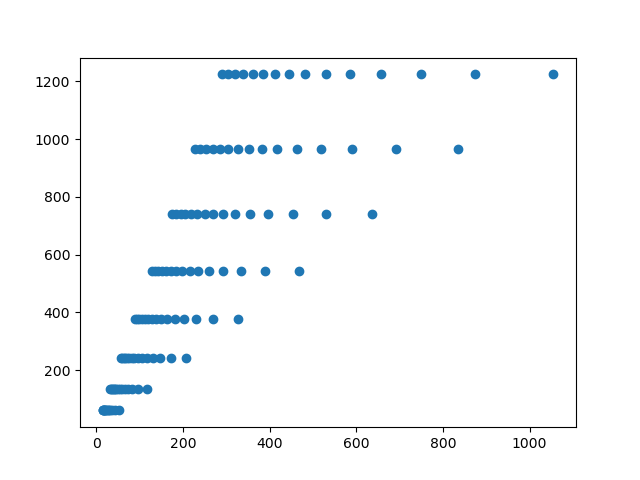

In [127]:
plt.figure()
plt.scatter(all_press, temps)
plt.show()

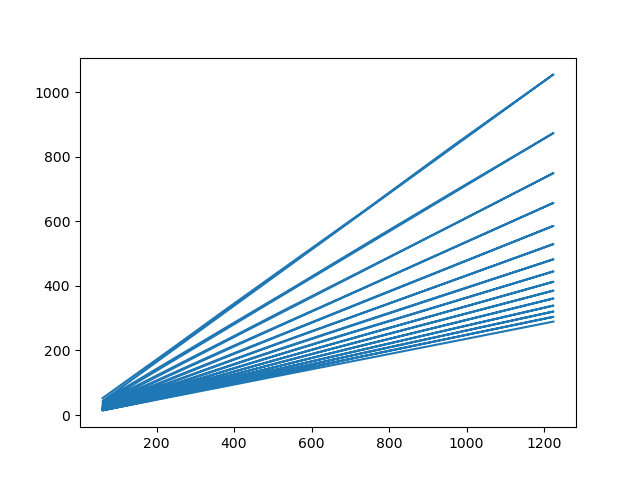

In [137]:
plt.figure()
plt.plot(temp, all_press)
plt.show()

In [1]:
# Volum
import scipy as sc
argans_radius = 0.1 * 1e-9
vol_change_rate = argans_radius / particle_radius
# So now my dim in these terms is: new_dim = dim * vol_change_rate
V = volum * vol_change_rate**2
sim_n = 500
N_A = sc.constants.Avogadro # Avogadro constant
N = num_particles # The number of molecules
molar_v = (V * N_A / N)
# molar_v = molar_v / 1000.0
print(f'moalr v is {molar_v}')
R = sc.constants.R   # universtal gas constant
b = 4 * (sc.constants.pi * (argans_radius)**2) * N_A
print(f'b is {b}')
a = 50
T = temp # Temp
# p_ideal = (sc.constants.R * T) / molar_v
# print(f'p ideal is {p_ideal} and measured pressure is {pressure}')
# p_vdw = ((sc.constants.R * T) / (molar_v - b)) - (a / (molar_v**2))
# p_vdw_noisy = p_vdw + np.random.normal(0, 0.6, len(p_vdw))
# input = {'molar_v': molar_v, 'T': T}

NameError: name 'particle_radius' is not defined

In [132]:
T

array([  60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014268,
        544.10420547,  740.58627966,  967.29636527, 1224.2344623 ,
         60.45602283,  136.02605137,  241.82409132,  377.85014

In [133]:
input = {'molar_v': molar_v, 'T': T}


In [138]:
from scipy.optimize import curve_fit
def idealGas(input, a_):
    return a_ * input['T'] / input['molar_v']

def vdw(input, a_, b_, c_):
    return ((a_ * input['T']) / (input['molar_v'] - b_)) + (c_ / (input['molar_v']**2))

def linear(input, a_, b_):
    return a_ * input['T'] + b_ * input['molar_v']

def cube(input, a_, b_, c_, d_, e_, f_):
    return (a_ * input['T'] + f_) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ / (input['molar_v']**3)

def fract(input, a_, b_, c_, d_, e_):
    return (a_ * input['molar_v']) / (d_ * input['T'] - b_) + c_ / (input['molar_v']**2) + e_ * input['T']

def vdw_linearT(input, a_, b_, c_, d_, e_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ * input['T']


def vdw_linearT2(input, a_, b_, c_, d_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2)

def vdw_linearT3(input, a_, b_, c_, d_, e_):
    return (a_ * input['T']) / (d_ * input['molar_v'] - b_) + c_ / (input['molar_v']**2) + e_ * input['molar_v']

def idealGas2(input, a_, b_):
    return a_ * input['T'] / input['molar_v'] + b_ * input['T']

def idealGas3(input, a_, b_, d_):
    return (a_ * input['T'] + d_) / input['molar_v'] + b_ * input['T']

func_dict = {'idealGas' : (idealGas, 1),
             'vdw' : (vdw, 3),
             'linear' : (linear, 2),
             'fract' : (fract, 5),
             'ideaGas2' : (idealGas2, 2),
             'idealGas3' : (idealGas3, 3),
             'vdw_linearT': (vdw_linearT, 5),
             'vdw_linearT2': (vdw_linearT2, 4),
             'vdw_linearT3': (vdw_linearT3, 5)}


In [139]:
loss = np.inf
chosen = ''
lam = 0.0
popt_save = 0
sim_n = len(all_press)

for key in func_dict:
    f, n_param = func_dict[key]
    p0 = [sc.constants.R]
    for i in range(n_param-1):
        p0.append(1)
    popt, pcov = curve_fit(f, input, all_press, method='lm')

    e = all_press - f(input, *popt)
    tmp_loss = np.sum(e**2)/sim_n + lam * n_param
    print(f'for {key}, the param is \n {popt} \n and loss is {tmp_loss}')
    if tmp_loss < loss:
        loss = tmp_loss
        print(tmp_loss)
        print(key)
        chosen = key
        popt_save = popt

for idealGas, the param is 
 [117251.69713005] 
 and loss is 2000.6675498527927
2000.6675498527927
idealGas
for vdw, the param is 
 [ 1.78663248e+05 -9.74879607e+04  1.00000000e+00] 
 and loss is 280.92578923532795
280.92578923532795
vdw
for linear, the param is 
 [ 5.12354846e-01 -1.73703712e-04] 
 and loss is 10968.953297781953
for fract, the param is 
 [-4.11158115e+00 -2.19695117e+04  1.00000000e+00 -1.37660892e+01
  6.65426152e-01] 
 and loss is 5588.990546880877
for ideaGas2, the param is 
 [8.87007170e+04 1.29876278e-01] 
 and loss is 4.912405891046928
4.912405891046928
ideaGas2
for idealGas3, the param is 
 [8.86921056e+04 1.29876278e-01 7.02674385e+03] 
 and loss is 4.9121507227336245
4.9121507227336245
idealGas3
for vdw_linearT, the param is 
 [-3.96232995e+05 -2.60302476e+03  1.00000000e+00 -4.48995981e+00
  1.30601740e-01] 
 and loss is 4.894429154063916
4.894429154063916
vdw_linearT
for vdw_linearT2, the param is 
 [ 8.25052640e+02 -4.50194688e+02  1.00000000e+00  4.617905

/tmp/ipykernel_5553/1752823443.py:12: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, pcov = curve_fit(f, input, all_press, method='lm')
